# _Session 3: Dimensionality Reduction & The Curse of Dimensionality_

## _From High Dimensions to Interpretable Visualizations_

## Learning Objectives
- Understand the curse of dimensionality and its impact on machine learning
- Learn why dimensionality reduction is essential for data analysis and visualization
- Master popular dimensionality reduction techniques (PCA, t-SNE, UMAP, LDA, etc.)
- Apply and compare different methods on real datasets
- Develop intuition for choosing the right technique for your problem

## Why This Topic Matters

Modern datasets often have **hundreds or thousands of features**:
- **Medical imaging**: MRI scans with millions of voxels
- **Genomics**: Gene expression with 20,000+ genes
- **Text data**: Documents with vocabulary of 100,000+ words
- **Sensor data**: IoT devices generating multi-dimensional time series

High dimensionality creates serious challenges:
- Models become slower and harder to train
- Data becomes increasingly sparse
- Visualization becomes impossible (we can only see 2-3 dimensions)

**The Solution**: Dimensionality reduction techniques that preserve important information while reducing dimensions.

In [27]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Dimensionality reduction algorithms
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD, FastICA
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# For demonstration
from sklearn.datasets import load_digits, load_breast_cancer, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## _Part 1: The Curse of Dimensionality_

### What is the Curse of Dimensionality?

The **curse of dimensionality** refers to various phenomena that arise when analyzing data in high-dimensional spaces that don't occur in low-dimensional settings.

### Key Problems:

1. **Data Sparsity**: As dimensions increase, data points become increasingly sparse
2. **Distance Concentration**: All points become approximately equidistant from each other
3. **Computational Complexity**: Exponential growth in computation and storage requirements
4. **Overfitting**: Models have too much freedom and memorize noise instead of learning patterns

### Demonstration 1: Data Sparsity in High Dimensions

**Question**: How many samples do we need to maintain the same data density as dimensions increase?

Let's explore this with a simple example: imagine sampling points uniformly in a unit hypercube [0,1]^d.

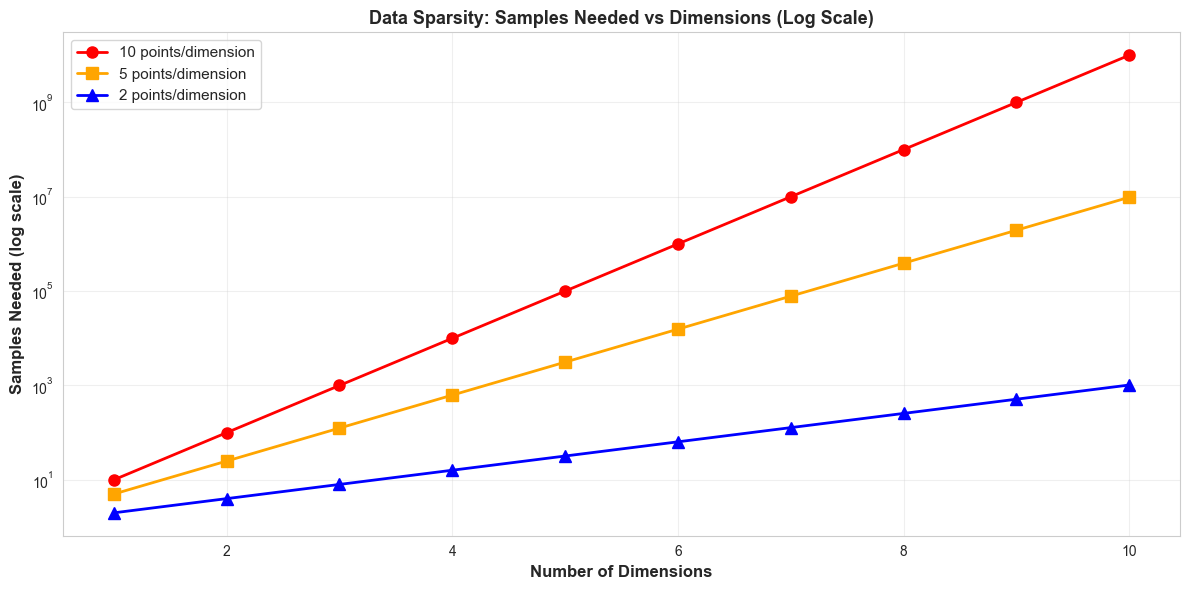

Exponential Growth of Sample Requirements:
Dimensions      2 pts/dim            5 pts/dim            10 pts/dim          
1               2                    5                    10                  
2               4                    25                   100                 
3               8                    125                  1,000               
5               32                   3,125                100,000             
10              1,024                9,765,625            10,000,000,000      


In [28]:
# Let's visualize how volume grows with dimensions
def samples_needed_for_coverage(dimensions, coverage=0.1, points_per_dimension=10):
    """
    Calculate samples needed to cover a fraction of the space.
    To cover 'coverage' fraction of a d-dimensional unit cube, 
    we need approximately (points_per_dimension)^d samples.
    """
    return points_per_dimension ** dimensions

dimensions = np.arange(1, 11)
samples_10 = [samples_needed_for_coverage(d, points_per_dimension=10) for d in dimensions]
samples_5 = [samples_needed_for_coverage(d, points_per_dimension=5) for d in dimensions]
samples_2 = [samples_needed_for_coverage(d, points_per_dimension=2) for d in dimensions]

# Create visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Log scale for better visualization
ax.semilogy(dimensions, samples_10, 'o-', linewidth=2, markersize=8, label='10 points/dimension', color='red')
ax.semilogy(dimensions, samples_5, 's-', linewidth=2, markersize=8, label='5 points/dimension', color='orange')
ax.semilogy(dimensions, samples_2, '^-', linewidth=2, markersize=8, label='2 points/dimension', color='blue')
ax.set_xlabel('Number of Dimensions', fontsize=12, fontweight='bold')
ax.set_ylabel('Samples Needed (log scale)', fontsize=12, fontweight='bold')
ax.set_title('Data Sparsity: Samples Needed vs Dimensions (Log Scale)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Exponential Growth of Sample Requirements:")
print("="*80)
print(f"{'Dimensions':<15} {'2 pts/dim':<20} {'5 pts/dim':<20} {'10 pts/dim':<20}")
print("="*80)
for d in [1, 2, 3, 5, 10]:
    print(f"{d:<15} {samples_needed_for_coverage(d, points_per_dimension=2):<20,} "
          f"{samples_needed_for_coverage(d, points_per_dimension=5):<20,} "
          f"{samples_needed_for_coverage(d, points_per_dimension=10):<20,}")

### Demonstration 2: Distance Concentration

In high dimensions, something counterintuitive happens: **all points become approximately the same distance from each other**.

This breaks distance-based algorithms like:
- k-Nearest Neighbors (KNN)
- k-Means Clustering
- Support Vector Machines (SVM)

Let's see this phenomenon in action!

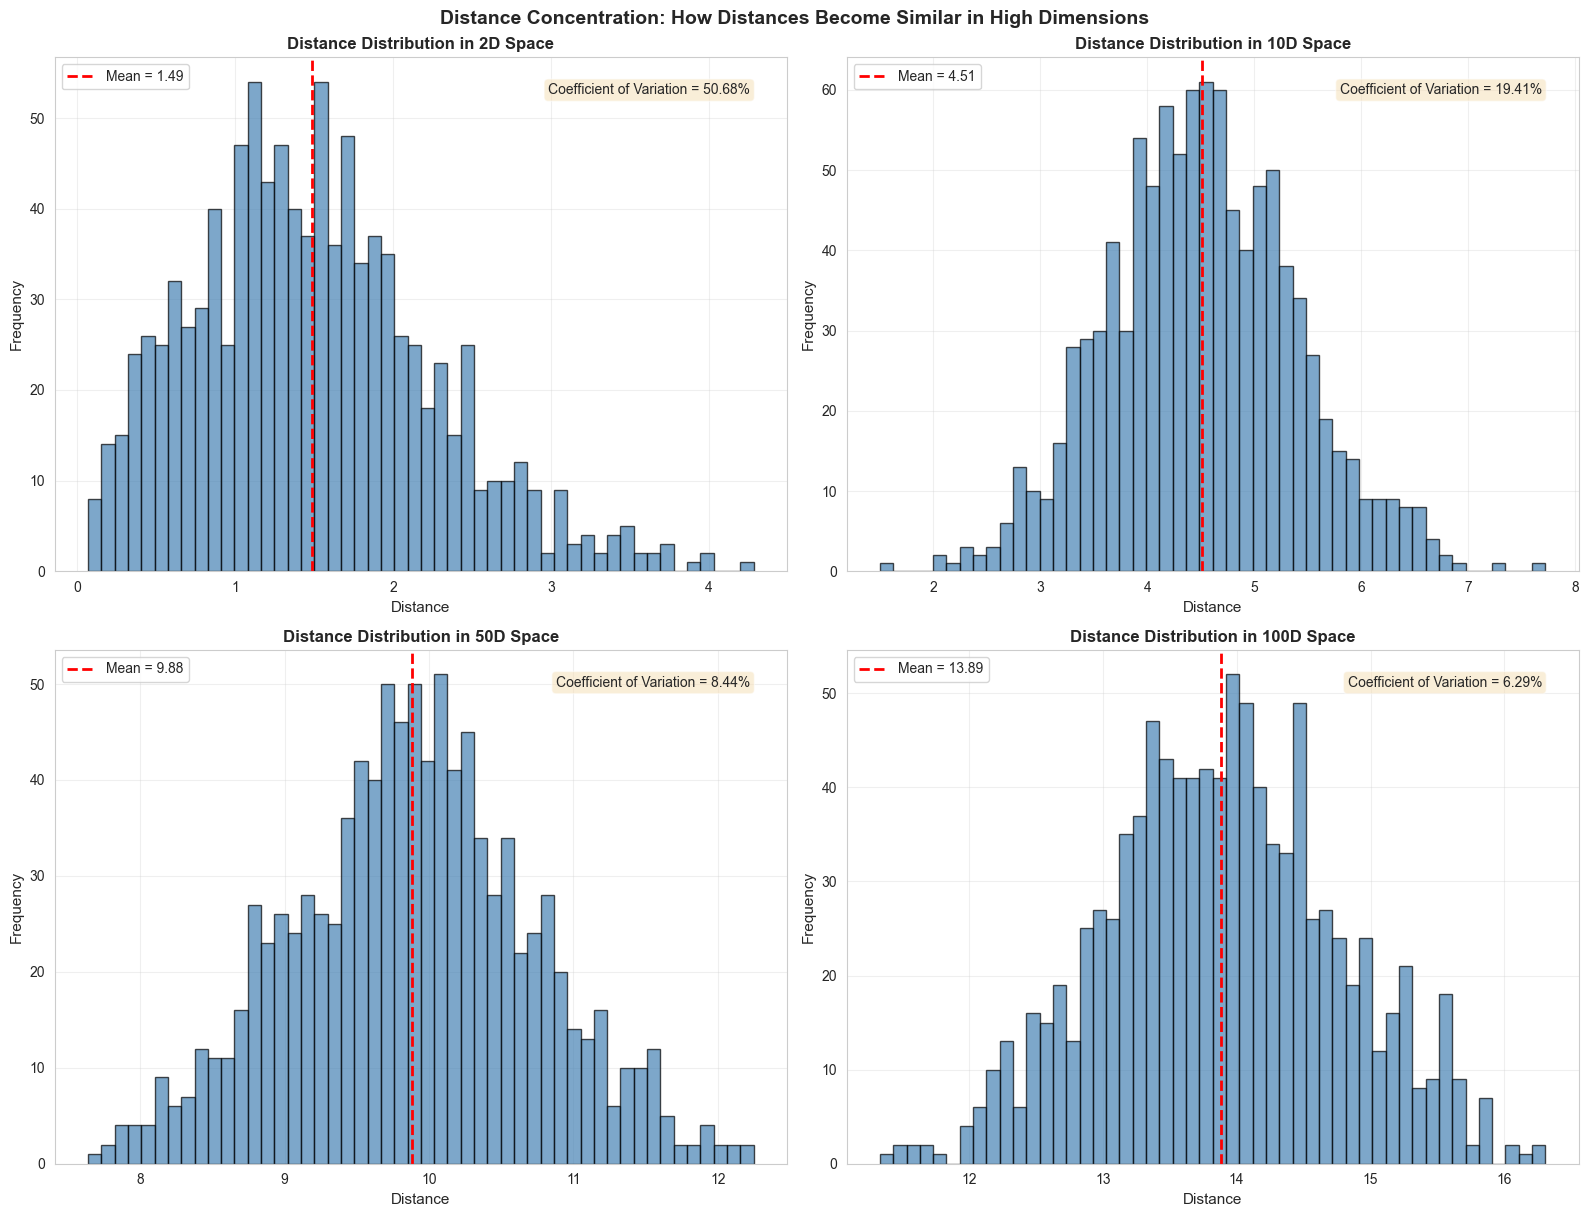


Distance Concentration Analysis:
Dimensions   Mean Dist    Std Dev      CV (%)       Min/Max Ratio  
1            0.85         0.64         74.87        0.001          
2            1.49         0.75         50.68        0.016          
5            2.97         0.89         29.85        0.125          
10           4.51         0.88         19.41        0.195          
20           7.06         0.90         12.77        0.467          
50           9.88         0.83         8.44         0.624          
100          13.89        0.87         6.29         0.695          


In [29]:
# Generate random data and compute pairwise distances
def distance_concentration_experiment(n_samples=1000, max_dims=100):
    """
    Demonstrate how distances concentrate in high dimensions.
    """
    dimensions = [1, 2, 5, 10, 20, 50, 100]
    results = []
    
    for d in dimensions:
        # Generate random points in d dimensions
        data = np.random.randn(n_samples, d)
        
        # Compute distances from first point to all others
        distances = np.sqrt(np.sum((data[1:] - data[0])**2, axis=1))
        
        results.append({
            'dimensions': d,
            'min_dist': distances.min(),
            'max_dist': distances.max(),
            'mean_dist': distances.mean(),
            'std_dist': distances.std(),
            'distances': distances
        })
    
    return results

# Run experiment
results = distance_concentration_experiment()

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distance distributions for different dimensions
for i, result in enumerate([results[1], results[3], results[5], results[6]]):
    ax = axes[i//2, i%2]
    ax.hist(result['distances'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(result['mean_dist'], color='red', linestyle='--', linewidth=2, label=f"Mean = {result['mean_dist']:.2f}")
    ax.set_xlabel('Distance', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f"Distance Distribution in {result['dimensions']}D Space", fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    # Add coefficient of variation
    cv = (result['std_dist'] / result['mean_dist']) * 100
    ax.text(0.95, 0.95, f"Coefficient of Variation = {cv:.2f}%", transform=ax.transAxes,
            ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)

plt.tight_layout()
plt.suptitle('Distance Concentration: How Distances Become Similar in High Dimensions', 
             y=1.01, fontsize=14, fontweight='bold')
plt.show()

# Print numerical summary
print("\nDistance Concentration Analysis:")
print("="*90)
print(f"{'Dimensions':<12} {'Mean Dist':<12} {'Std Dev':<12} {'CV (%)':<12} {'Min/Max Ratio':<15}")
print("="*90)
for result in results:
    cv = (result['std_dist'] / result['mean_dist']) * 100
    ratio = result['min_dist'] / result['max_dist']
    print(f"{result['dimensions']:<12} {result['mean_dist']:<12.2f} {result['std_dist']:<12.2f} "
          f"{cv:<12.2f} {ratio:<15.3f}")

### Summary: Why the Curse of Dimensionality Matters

| Problem | Impact | Example |
|---------|--------|----------|
| **Data Sparsity** | Need exponentially more samples | 10D space needs 10 billion points for same density as 100 points in 2D |
| **Distance Concentration** | Distance-based methods fail | KNN can't find "nearest" neighbors when all points are equidistant |
| **Overfitting** | Models memorize noise | Too many features → model has too much freedom |
| **Computational Cost** | Training becomes infeasible | Time and memory grow exponentially |

**The Bottom Line**:
- ❌ High dimensions make learning harder, not easier
- ❌ More features ≠ better model (often the opposite!)
- ✅ Dimensionality reduction is not just helpful—it's **essential**

## _Part 2: Why Do We Need Dimensionality Reduction?_

Now that we understand the curse of dimensionality, let's explore the **benefits** of dimensionality reduction.

### Main Motivations:

#### 1. **Visualization** 
- Humans can only visualize 2-3 dimensions
- Reduce high-dimensional data to 2D/3D for plotting
- Discover patterns, clusters, outliers visually
- **Most important for exploratory data analysis**

#### 2. **Computational Efficiency** 
- Fewer dimensions → faster training
- Lower memory requirements
- Enable real-time predictions

#### 3. **Noise Reduction** 
- Remove irrelevant or redundant features
- Focus on signal, discard noise
- Improve model generalization

#### 4. **Avoid Overfitting** 
- Reduce model complexity
- Better generalization to new data
- Regularization effect

#### 5. **Feature Understanding** 
- Identify most important directions in data
- Understand feature relationships
- Domain insight and interpretation

### Types of Dimensionality Reduction

Dimensionality reduction methods fall into two main categories:

#### **1. Linear Methods**
Assume data lies on or near a linear subspace
- ✅ Fast and scalable
- ✅ Interpretable results
- ❌ Can't capture complex nonlinear patterns

**Examples**: PCA, LDA, SVD, ICA

#### **2. Nonlinear Methods (Manifold Learning)**
Can capture complex curved structures in data
- ✅ Discover complex patterns
- ✅ Better for visualization of complex data
- ❌ Slower and less scalable
- ❌ Harder to interpret

**Examples**: t-SNE, UMAP, Isomap, LLE, MDS

### Comparison Overview:

| Method | Type | Best For | Preserves | Speed | Parameters |
|--------|------|----------|-----------|-------|------------|
| **PCA** | Linear | General purpose, visualization | Global structure, variance | ⚡⚡⚡ Fast | n_components |
| **LDA** | Linear | Classification | Class separation | ⚡⚡⚡ Fast | n_components |
| **t-SNE** | Nonlinear | Visualization, clustering | Local structure | ⚡ Slow | perplexity, learning_rate |
| **UMAP** | Nonlinear | Visualization, clustering | Local + global | ⚡⚡ Medium | n_neighbors, min_dist |
| **Isomap** | Nonlinear | Manifolds | Geodesic distances | ⚡⚡ Medium | n_neighbors |
| **LLE** | Nonlinear | Manifolds | Local geometry | ⚡⚡ Medium | n_neighbors |
| **MDS** | Linear/Nonlinear | Distances | Pairwise distances | ⚡ Slow | metric (True/False) |

## _Part 3: Dimensionality Reduction for Visualization_

### Why Visualization Matters

**"A picture is worth a thousand words"** — especially in data science!

Visualization helps us:
-  **See patterns** that are invisible in raw numbers
-  **Identify clusters** and group structures
-  **Spot outliers** and anomalies
-  **Generate hypotheses** about the data
-  **Communicate findings** to stakeholders

### The Visualization Challenge:

| Data Dimensions | Visualization |
|----------------|---------------|
| 1D | Line plot, histogram |
| 2D | Scatter plot |
| 3D | 3D scatter (limited usefulness) |
| 4D+ | **Impossible to visualize directly!** |

**Solution**: Use dimensionality reduction to project high-dimensional data into 2D or 3D!

### Best Methods for Visualization:

1. **PCA (2D/3D)**: Quick overview, see main directions of variance
2. **t-SNE (2D)**: Beautiful cluster visualization, reveals local structure
3. **UMAP (2D/3D)**: Best of both worlds—fast, preserves local and global structure
4. **LDA (2D/3D)**: When you want to see class separation

Let's load a real dataset and demonstrate!

## _Part 4: Hands-On — Applying Dimensionality Reduction Algorithms_

### Dataset: Handwritten Digits (MNIST Subset)

We'll use the classic **digits dataset**:
- **Features**: 64 pixel values (8×8 images)
- **Samples**: 1,797 handwritten digits
- **Classes**: 10 digits (0-9)
- **Challenge**: Visualize 64-dimensional data in 2D!

This is perfect for demonstrating dimensionality reduction because:
- ✅ High-dimensional (64D)
- ✅ Known classes for validation
- ✅ Real-world relevance
- ✅ Fast to compute

Dataset Information:
Number of samples: 1,797
Number of features: 64 (8×8 pixel values)
Number of classes: 10 (digits 0-9)
Feature range: [0.0, 16.0]

Class Distribution:
  Digit 0: 178 samples (9.9%)
  Digit 1: 182 samples (10.1%)
  Digit 2: 177 samples (9.8%)
  Digit 3: 183 samples (10.2%)
  Digit 4: 181 samples (10.1%)
  Digit 5: 182 samples (10.1%)
  Digit 6: 181 samples (10.1%)
  Digit 7: 179 samples (10.0%)
  Digit 8: 174 samples (9.7%)
  Digit 9: 180 samples (10.0%)


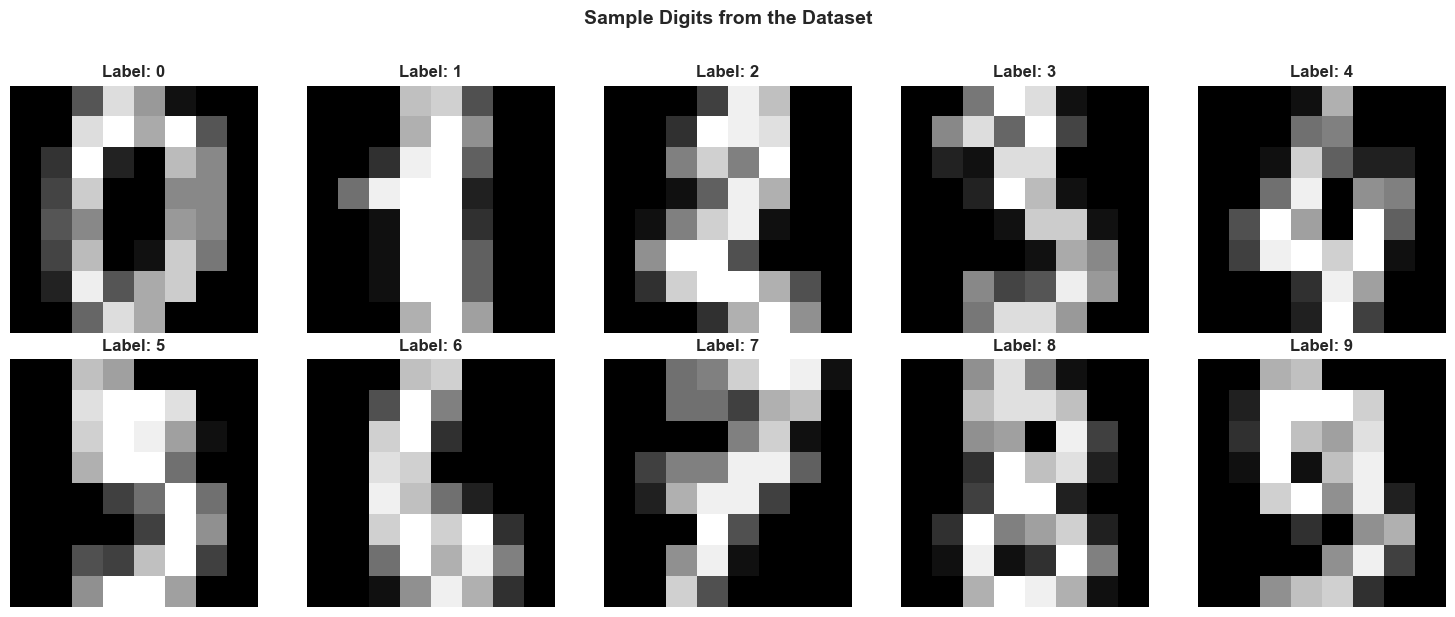


✓ Features standardized (mean=0, std=1)
  Mean: 0.000000
  Std:  0.976281


In [30]:
# Load the digits dataset
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print("Dataset Information:")
print("="*80)
print(f"Number of samples: {X_digits.shape[0]:,}")
print(f"Number of features: {X_digits.shape[1]} (8×8 pixel values)")
print(f"Number of classes: {len(np.unique(y_digits))} (digits 0-9)")
print(f"Feature range: [{X_digits.min():.1f}, {X_digits.max():.1f}]")
print("="*80)

# Display class distribution
print("\nClass Distribution:")
unique, counts = np.unique(y_digits, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"  Digit {digit}: {count:3d} samples ({count/len(y_digits)*100:.1f}%)")

# Visualize some example digits
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_digits[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Label: {y_digits[i]}", fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('Sample Digits from the Dataset', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Standardize the features (important for most DR algorithms!)
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)

print("\n✓ Features standardized (mean=0, std=1)")
print(f"  Mean: {X_digits_scaled.mean():.6f}")
print(f"  Std:  {X_digits_scaled.std():.6f}")

### Algorithm 1: Principal Component Analysis (PCA)

#### What is PCA?
**Principal Component Analysis** finds orthogonal directions (principal components) that capture maximum variance in the data.

#### How it works:
1. Center the data (subtract mean)
2. Compute covariance matrix
3. Find eigenvectors (principal components) and eigenvalues
4. Project data onto top k eigenvectors

#### Key Properties:
- ✅ **Fast**: Works well even with thousands of features
- ✅ **Deterministic**: Same result every time
- ✅ **Interpretable**: Components show directions of maximum variance
- ✅ **Reversible**: Can reconstruct approximate original data
- ❌ **Linear only**: Can't capture nonlinear patterns
- ❌ **Global**: May miss local structure

#### When to use PCA:
- First dimensionality reduction to try (baseline)
- Noise reduction and feature extraction
- Preprocessing before other algorithms
- Understanding variance structure

#### Main Parameter:
- **n_components**: Number of dimensions to keep (e.g., 2 for visualization)

Applying PCA...
Original dimensions: 64
Reduced dimensions:  2
Explained variance ratio: [0.12033916 0.09561054]
Total variance explained: 21.59%


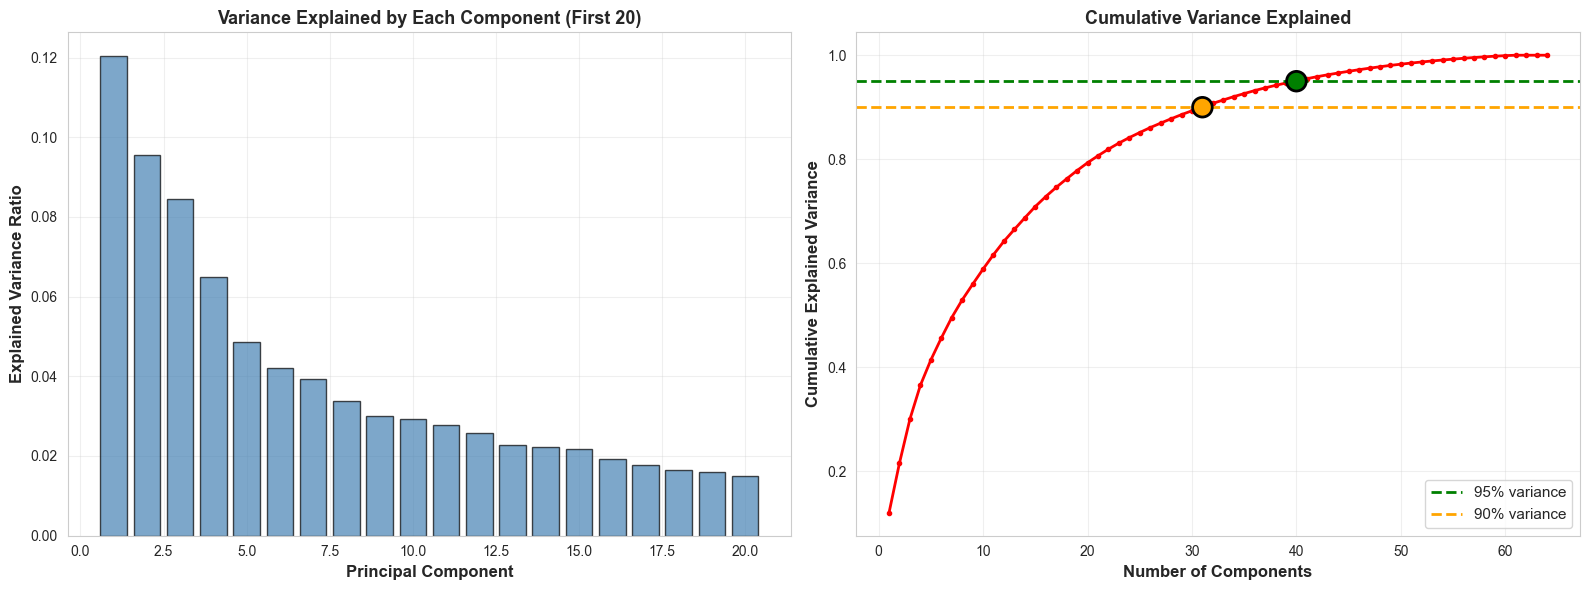

In [31]:
# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_digits_scaled)

print("="*80)
print(f"Original dimensions: {X_digits_scaled.shape[1]}")
print(f"Reduced dimensions:  {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print("="*80)

# Visualize explained variance
pca_full = PCA(random_state=42)
pca_full.fit(X_digits_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Explained variance per component
axes[0].bar(range(1, 21), pca_full.explained_variance_ratio_[:20], alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Variance Explained by Each Component (First 20)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Cumulative explained variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, len(cumsum)+1), cumsum, linewidth=2, color='red', marker='o', markersize=3)
axes[1].axhline(y=0.95, color='green', linestyle='--', linewidth=2, label='95% variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% variance')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

# Find how many components for 90% and 95% variance
n_90 = np.argmax(cumsum >= 0.90) + 1
n_95 = np.argmax(cumsum >= 0.95) + 1
axes[1].scatter([n_90, n_95], [0.90, 0.95], s=200, c=['orange', 'green'], 
                edgecolors='black', linewidth=2, zorder=5)

plt.tight_layout()
plt.show()

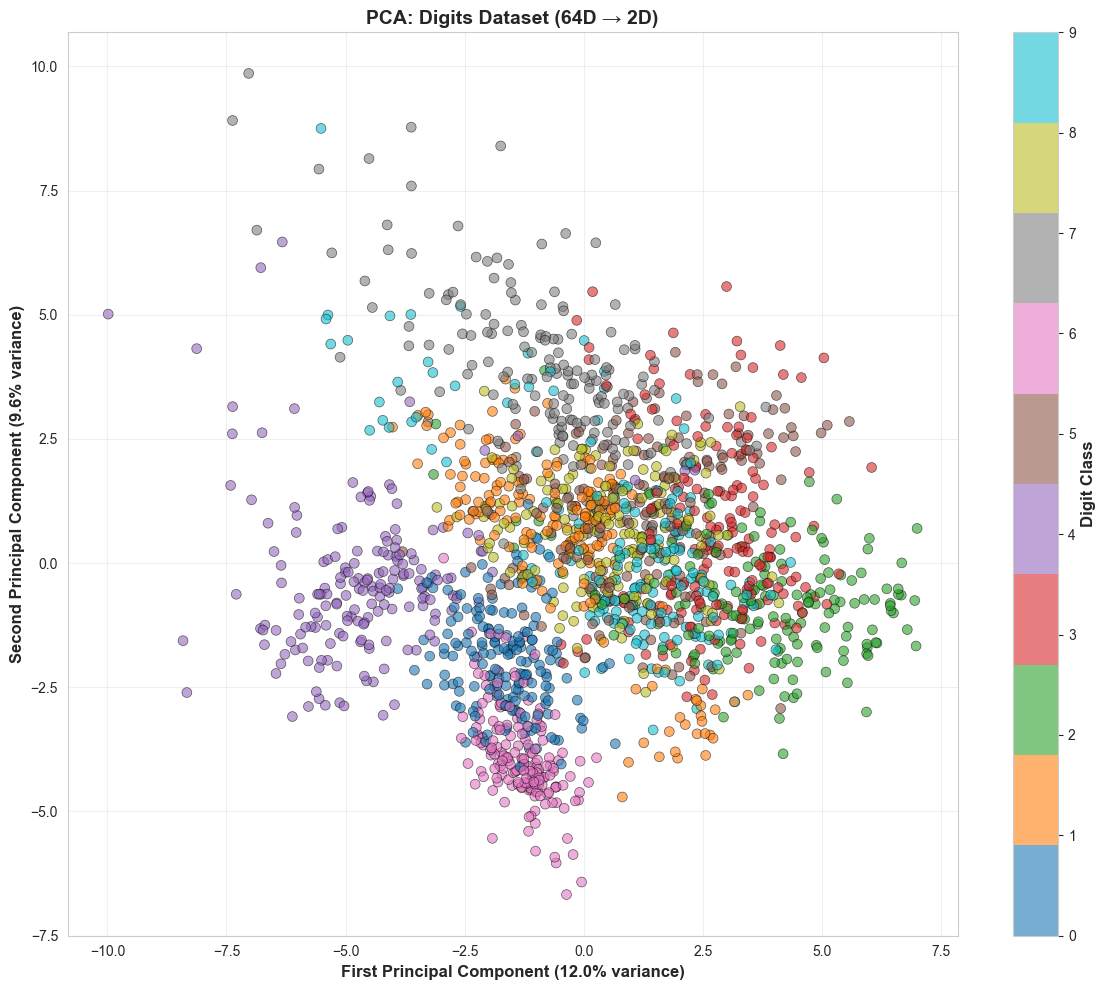

In [32]:
# Visualize PCA in 2D
fig, ax = plt.subplots(figsize=(12, 10))

# Create scatter plot with different colors for each digit
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_digits, cmap='tab10', 
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
cbar.set_label('Digit Class', fontsize=12, fontweight='bold')

ax.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_title('PCA: Digits Dataset (64D → 2D)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Algorithm 2: Linear Discriminant Analysis (LDA)

#### What is LDA?
**Linear Discriminant Analysis** finds directions that maximize class separation (supervised method).

#### How it works:
1. Compute within-class and between-class scatter matrices
2. Find directions that maximize between-class variance while minimizing within-class variance
3. Project data onto these discriminant directions

#### Key Properties:
- ✅ **Supervised**: Uses class labels to find separating directions
- ✅ **Good for classification**: Maximizes class separation
- ✅ **Fast**: Similar speed to PCA
- ❌ **Limited components**: Max n_components = n_classes - 1
- ❌ **Assumes Gaussian**: Works best when classes are normally distributed

#### When to use LDA:
- You have labeled data and want to visualize class separation
- Preprocessing for classification tasks
- Comparing with PCA to see if labels help

#### Main Parameter:
- **n_components**: Number of discriminant components (max = n_classes - 1)

Applying LDA...
Original dimensions: 64
Reduced dimensions:  2
Explained variance ratio: [0.28912041 0.18262788]
Total variance explained: 47.17%


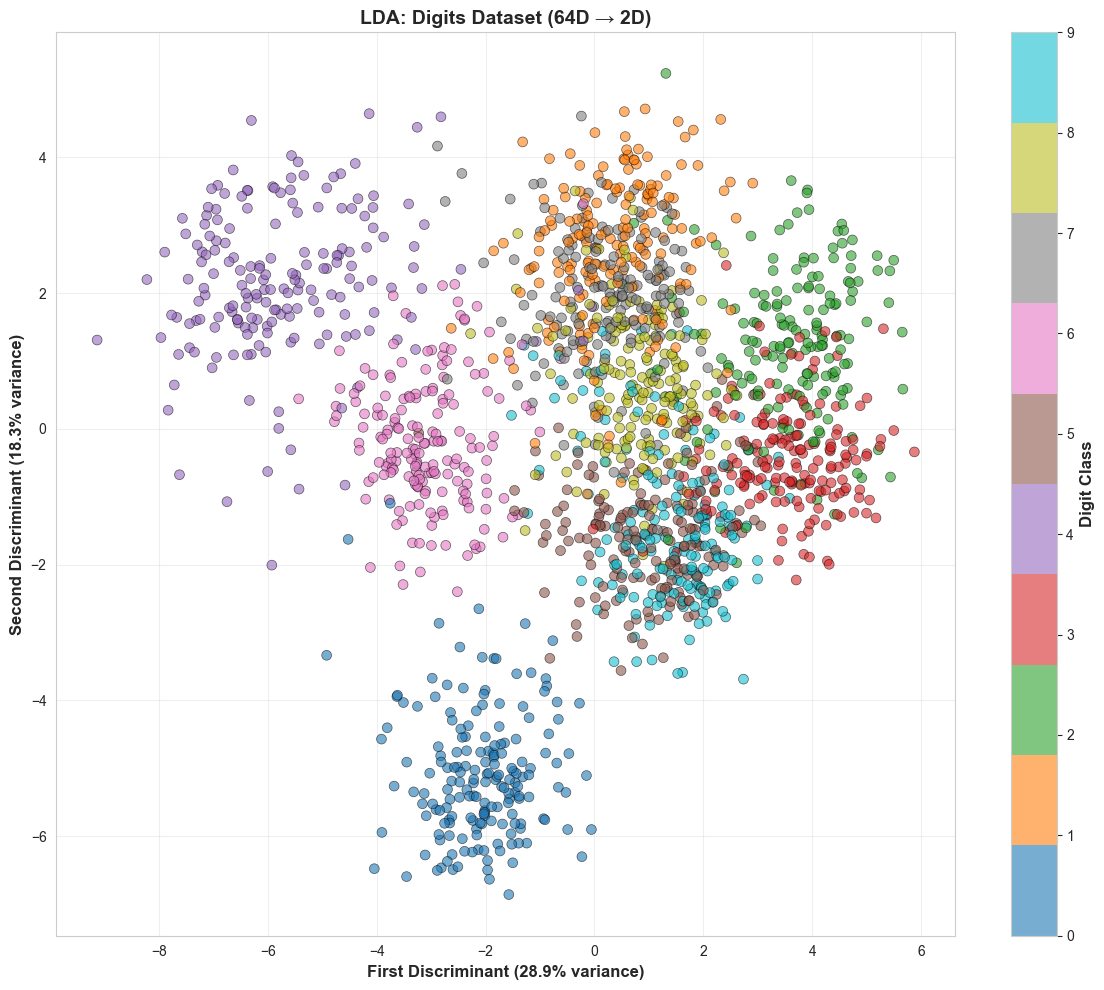

In [33]:
# Apply LDA
print("Applying LDA...")
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_digits_scaled, y_digits)

print("="*80)
print(f"Original dimensions: {X_digits_scaled.shape[1]}")
print(f"Reduced dimensions:  {X_lda.shape[1]}")
print(f"Explained variance ratio: {lda.explained_variance_ratio_}")
print(f"Total variance explained: {lda.explained_variance_ratio_.sum()*100:.2f}%")
print("="*80)

# Visualize LDA in 2D
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(X_lda[:, 0], X_lda[:, 1], c=y_digits, cmap='tab10',
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
cbar.set_label('Digit Class', fontsize=12, fontweight='bold')

ax.set_xlabel(f'First Discriminant ({lda.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'Second Discriminant ({lda.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_title('LDA: Digits Dataset (64D → 2D)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Algorithm 3: t-Distributed Stochastic Neighbor Embedding (t-SNE)

#### What is t-SNE?
**t-SNE** is a nonlinear technique particularly good at preserving **local structure** for visualization.

#### How it works:
1. Compute pairwise similarities in high-dimensional space (using Gaussian)
2. Initialize random low-dimensional embedding
3. Compute pairwise similarities in low-dimensional space (using t-distribution)
4. Iteratively adjust embedding to match the similarity distributions

#### Key Properties:
- ✅ **Excellent for visualization**: Creates beautiful, interpretable 2D plots
- ✅ **Reveals clusters**: Groups similar points together
- ✅ **Nonlinear**: Captures complex manifold structure
- ❌ **Slow**: Quadratic complexity O(n²), struggles with large datasets
- ❌ **Stochastic**: Different results each run (use random_state!)
- ❌ **Not for dimensionality reduction per se**: Distances in 2D are not meaningful
- ❌ **Hyperparameter sensitive**: Results depend heavily on perplexity

#### When to use t-SNE:
- **Primary use**: Visualization of high-dimensional data
- Exploring cluster structure
- Generating publication-quality plots
- Datasets with < 10,000 samples (for reasonable speed)

#### Important Parameters:
- **perplexity** (5-100): Balances local vs global structure. Think of it as "expected number of neighbors"
  - Low perplexity (5-15): Focus on very local structure, tight clusters
  - Medium perplexity (30-50): Balanced — **good default**
  - High perplexity (50-100): More global structure, spread out
  - **Rule of thumb**: perplexity should be smaller than the number of points
- **learning_rate** (10-1000): Step size for optimization (default: 200)
- **max_iter**: Number of iterations (1000-5000 for convergence)

#### ⚠️ Common Mistakes:
- **Interpreting distances between clusters** (not meaningful!)
- Using for dimensionality reduction before modeling (use PCA instead)
- Not trying different perplexity values
- Using perplexity > number of data points

Applying t-SNE (this may take a minute)...
Original dimensions: 64
Reduced dimensions:  2
Final KL divergence: 0.8317


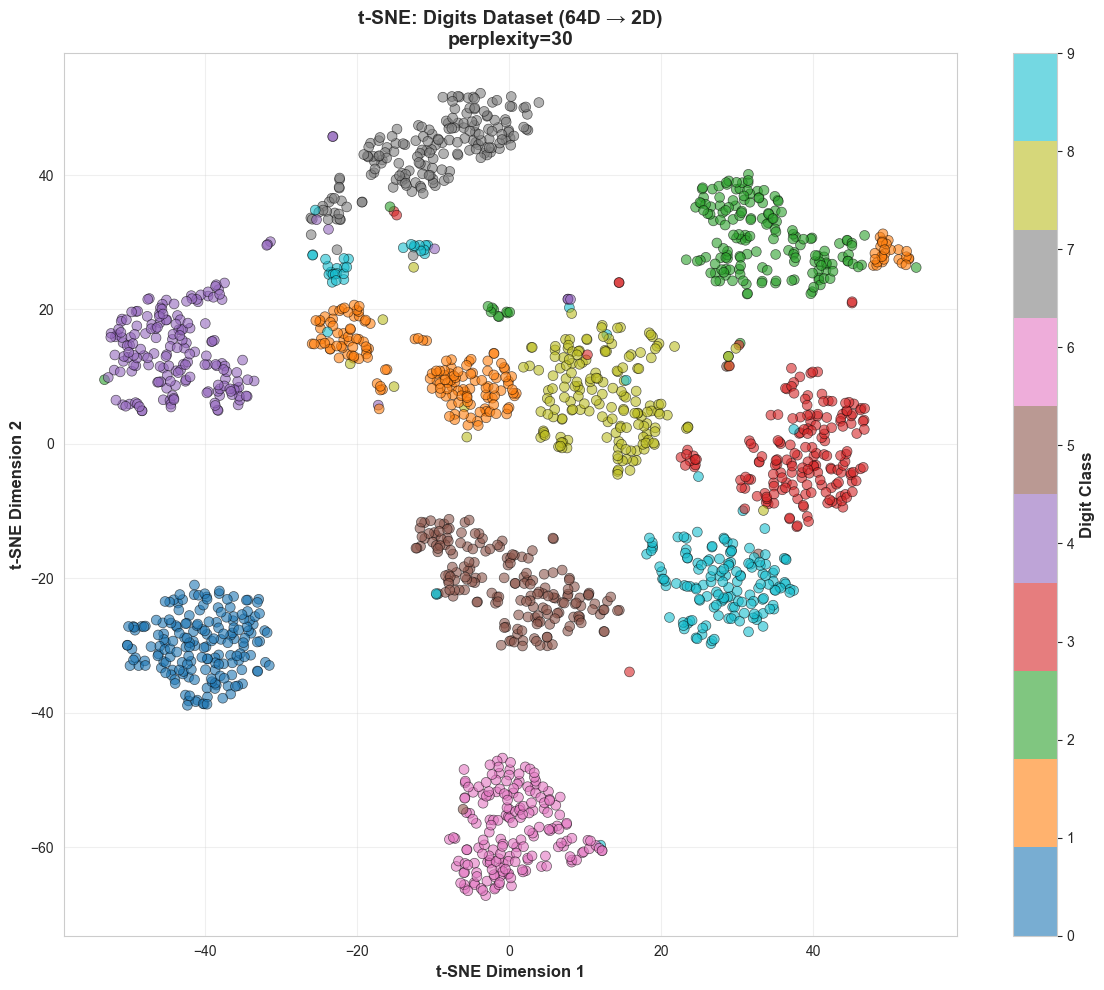


🔍 Observations:
  • Much clearer clusters than PCA or LDA!
  • Different digits form distinct, well-separated groups
  • Local structure preserved — similar digits are close together
  ⚠️ Remember: Distances BETWEEN clusters are not meaningful!


In [ ]:
# Apply t-SNE
print("Applying t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_digits_scaled)

print("="*80)
print(f"Original dimensions: {X_digits_scaled.shape[1]}")
print(f"Reduced dimensions:  {X_tsne.shape[1]}")
print(f"Final KL divergence: {tsne.kl_divergence_:.4f}")
print("="*80)

# Visualize t-SNE in 2D
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_digits, cmap='tab10',
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
cbar.set_label('Digit Class', fontsize=12, fontweight='bold')

ax.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('t-SNE: Digits Dataset (64D → 2D)\nperplexity=30', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Comparing different perplexity values...

Running t-SNE with perplexity=5...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=100...


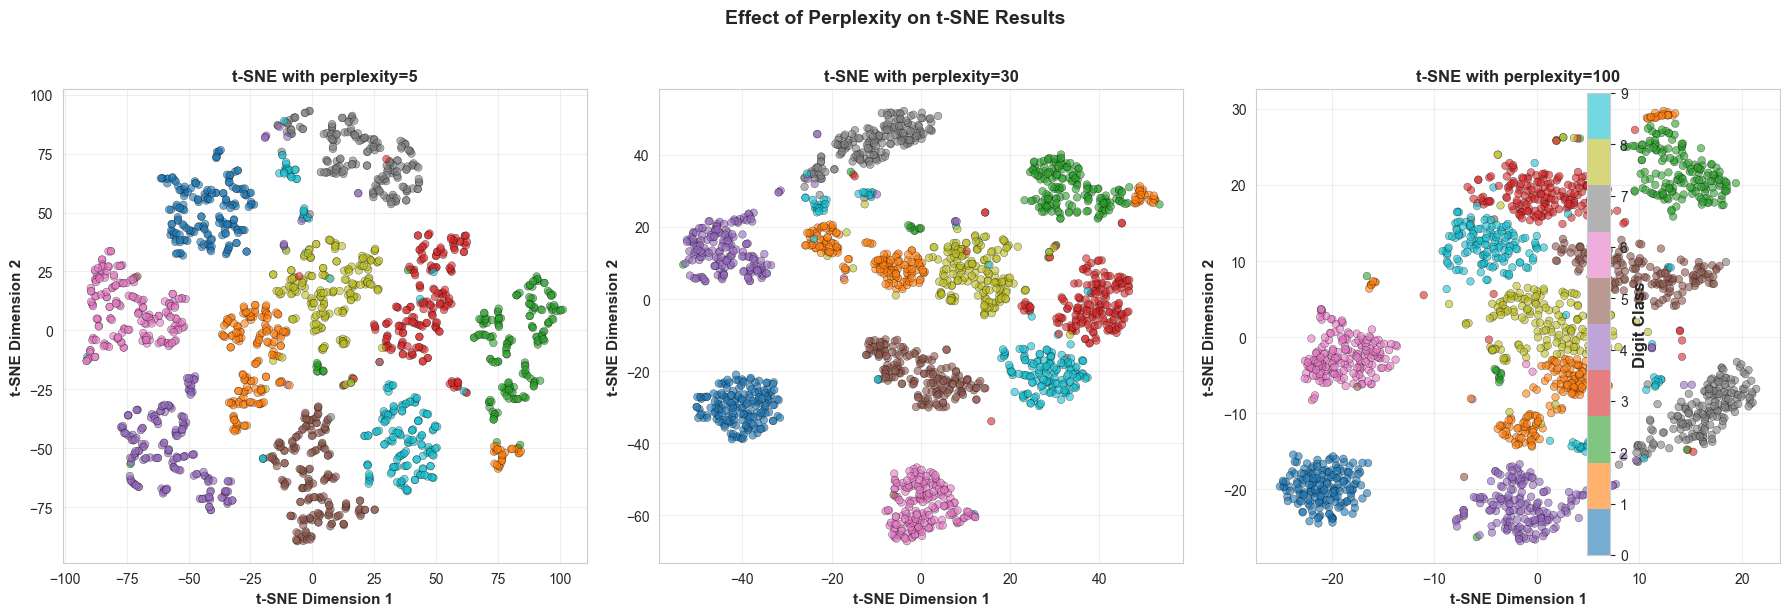


💡 Insight: Perplexity affects cluster structure!
  • Low perplexity (5): Very tight, small clusters — focuses on nearest neighbors
  • Medium perplexity (30): Balanced local and global structure — good default
  • High perplexity (100): Emphasizes global structure — clusters more spread out


In [41]:
# Compare different perplexity values
print("Comparing different perplexity values...\n")
perplexities = [5, 30, 100]  # Changed from [5, 30, 50] to [5, 30, 100] for clearer differences

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, perp in enumerate(perplexities):
    print(f"Running t-SNE with perplexity={perp}...")
    tsne_temp = TSNE(n_components=2, perplexity=perp, learning_rate=200, max_iter=1000, random_state=42)
    X_tsne_temp = tsne_temp.fit_transform(X_digits_scaled)
    
    scatter = axes[idx].scatter(X_tsne_temp[:, 0], X_tsne_temp[:, 1], c=y_digits, cmap='tab10',
                                alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
    
    axes[idx].set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
    axes[idx].set_title(f't-SNE with perplexity={perp}', fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)

# Add colorbar
cbar = fig.colorbar(scatter, ax=axes, ticks=range(10), fraction=0.02, pad=0.04)
cbar.set_label('Digit Class', fontsize=12, fontweight='bold')

plt.suptitle('Effect of Perplexity on t-SNE Results', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Insight: Perplexity affects cluster structure!")
print("  • Low perplexity (5): Very tight, small clusters — focuses on nearest neighbors")
print("  • Medium perplexity (30): Balanced local and global structure — good default")
print("  • High perplexity (100): Emphasizes global structure — clusters more spread out")

### Algorithm 4: Uniform Manifold Approximation and Projection (UMAP)

#### What is UMAP?
**UMAP** is a modern manifold learning technique that is **faster** than t-SNE and preserves **both local and global** structure.

#### How it works:
1. Construct a fuzzy topological representation of high-dimensional data
2. Find a low-dimensional projection that best preserves this structure
3. Use stochastic gradient descent to optimize the embedding

#### Key Properties:
- ✅ **Fast**: Much faster than t-SNE (scales to millions of points)
- ✅ **Preserves local AND global structure**: Better than t-SNE for overall data structure
- ✅ **Deterministic** (with fixed random_state): More reproducible than t-SNE
- ✅ **Can generalize**: Can transform new data (unlike t-SNE)
- ❌ **Newer method**: Less well-studied than t-SNE
- ❌ **Requires extra library**: Need to install `umap-learn`

#### When to use UMAP:
- Large datasets (> 10,000 samples)
- When you want to preserve global structure
- When you need to transform new data points
- Modern alternative to t-SNE

#### Important Parameters:
- **n_neighbors** (2-100): Size of local neighborhood (similar to perplexity in t-SNE)
  - Low: Focus on local structure
  - High: More global structure
- **min_dist** (0.0-1.0): Minimum distance between points in embedding
  - Low (0.0): Tightly packed clusters
  - High (0.99): More spread out

#### Note:
UMAP requires the `umap-learn` package. If not installed, we'll skip this section.
Install with: `pip install umap-learn`

Applying UMAP...
Original dimensions: 64
Reduced dimensions:  2


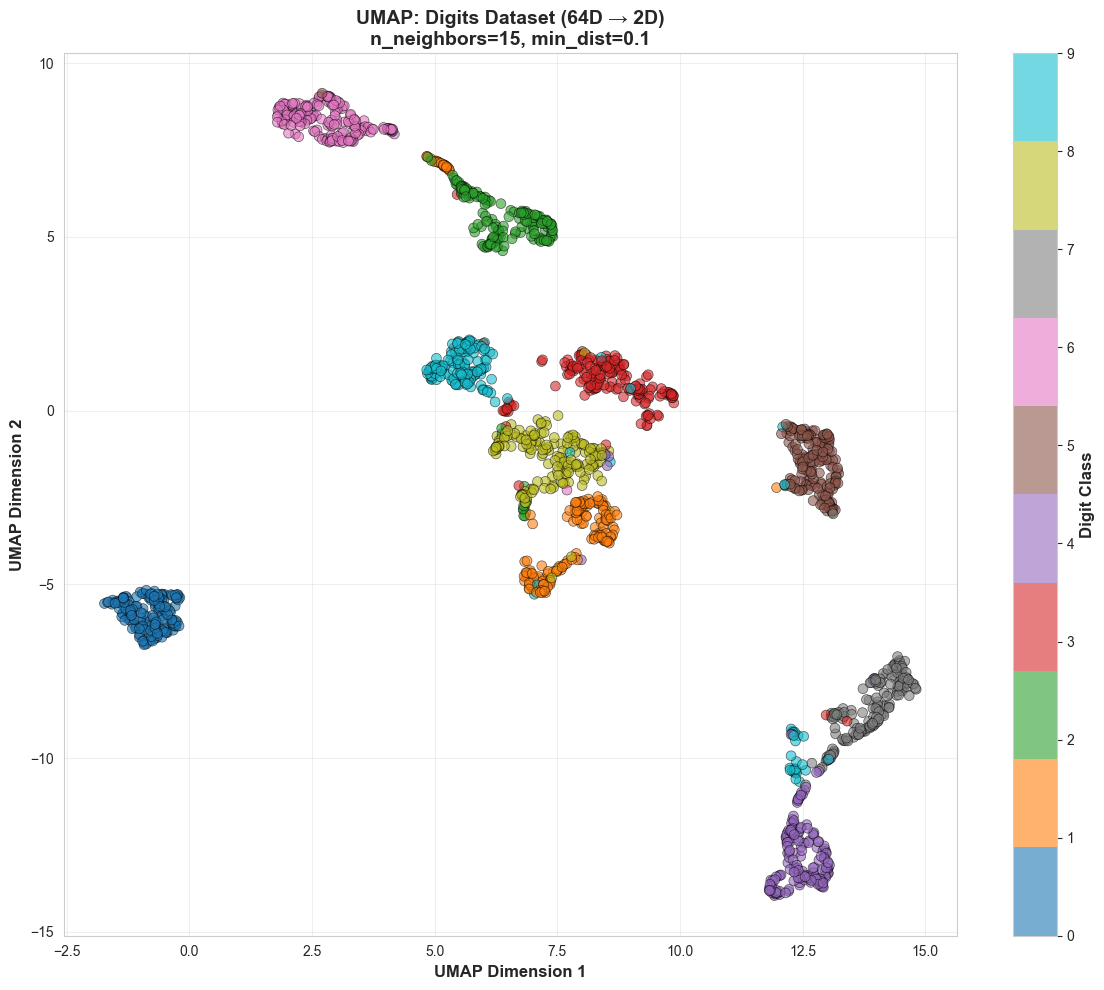


🔍 Observations:
  • Clear cluster separation, similar to t-SNE
  • Better preservation of global structure
  • Much faster than t-SNE!
  • Can be used to transform new data points


In [42]:
# Try to import UMAP
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️ UMAP not available. Install with: pip install umap-learn")
    print("   Skipping UMAP demonstration.\n")

if UMAP_AVAILABLE:
    # Apply UMAP
    print("Applying UMAP...")
    umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap_reducer.fit_transform(X_digits_scaled)
    
    print("="*80)
    print(f"Original dimensions: {X_digits_scaled.shape[1]}")
    print(f"Reduced dimensions:  {X_umap.shape[1]}")
    print("="*80)
    
    # Visualize UMAP in 2D
    fig, ax = plt.subplots(figsize=(12, 10))
    
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y_digits, cmap='tab10',
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
    cbar.set_label('Digit Class', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
    ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
    ax.set_title('UMAP: Digits Dataset (64D → 2D)\nn_neighbors=15, min_dist=0.1', 
                 fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n🔍 Observations:")
    print("  • Clear cluster separation, similar to t-SNE")
    print("  • Better preservation of global structure")
    print("  • Much faster than t-SNE!")
    print("  • Can be used to transform new data points")

### Algorithm 5: Isomap (Isometric Mapping)

#### What is Isomap?
**Isomap** extends classical MDS by preserving **geodesic distances** (distances along the manifold).

#### How it works:
1. Construct k-nearest neighbor graph
2. Compute shortest path distances between all pairs (geodesic distances)
3. Apply classical MDS to preserve these distances in low dimensions

#### Key Properties:
- ✅ **Theoretically well-founded**: Strong mathematical guarantees
- ✅ **Preserves geodesic distances**: Good for curved manifolds
- ✅ **Deterministic**: Same result every time
- ❌ **Sensitive to noise**: Short-circuit errors can break the manifold
- ❌ **Computational cost**: Needs to compute all-pairs shortest paths

#### When to use Isomap:
- Data lies on a smooth, curved manifold
- You want to preserve geodesic distances
- Low-noise datasets

#### Main Parameter:
- **n_neighbors**: Number of neighbors for graph construction

Applying Isomap...
Original dimensions: 64
Reduced dimensions:  2
Reconstruction error: 105.2396


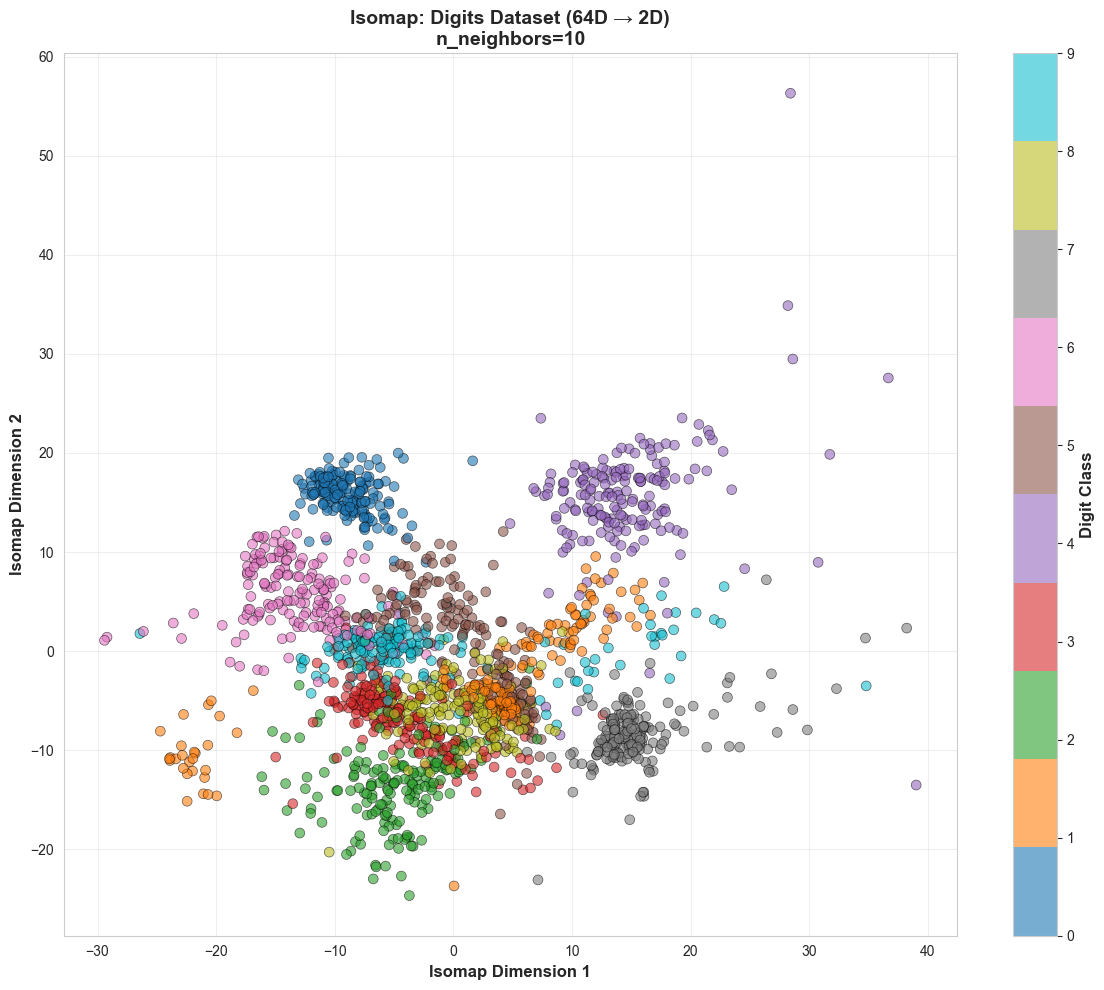


🔍 Observations:
  • Some cluster structure visible
  • Preserves geodesic (manifold) distances
  • May not separate clusters as clearly as t-SNE/UMAP


In [37]:
# Apply Isomap
print("Applying Isomap...")
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X_digits_scaled)

print("="*80)
print(f"Original dimensions: {X_digits_scaled.shape[1]}")
print(f"Reduced dimensions:  {X_isomap.shape[1]}")
print(f"Reconstruction error: {isomap.reconstruction_error():.4f}")
print("="*80)

# Visualize Isomap in 2D
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(X_isomap[:, 0], X_isomap[:, 1], c=y_digits, cmap='tab10',
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
cbar.set_label('Digit Class', fontsize=12, fontweight='bold')

ax.set_xlabel('Isomap Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('Isomap Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('Isomap: Digits Dataset (64D → 2D)\nn_neighbors=10', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Observations:")
print("  • Some cluster structure visible")
print("  • Preserves geodesic (manifold) distances")
print("  • May not separate clusters as clearly as t-SNE/UMAP")

### Algorithm 6: Locally Linear Embedding (LLE)

#### What is LLE?
**LLE** preserves local linear relationships by reconstructing each point from its neighbors.

#### How it works:
1. Find k-nearest neighbors for each point
2. Compute weights that reconstruct each point from neighbors
3. Find low-dimensional embedding that preserves these weights

#### Key Properties:
- ✅ **Preserves local geometry**: Good for manifolds
- ✅ **No iterative optimization**: Solves eigenvalue problem
- ✅ **Theoretically elegant**: Strong mathematical foundation
- ❌ **Sensitive to noise**: Outliers can break local linearity
- ❌ **Can produce distortions**: May not preserve global structure

#### When to use LLE:
- Data lies on a locally linear manifold
- You want to preserve local relationships
- Alternative to Isomap

#### Main Parameter:
- **n_neighbors**: Number of neighbors for reconstruction

Applying LLE...
Original dimensions: 64
Reduced dimensions:  2
Reconstruction error: 0.0000


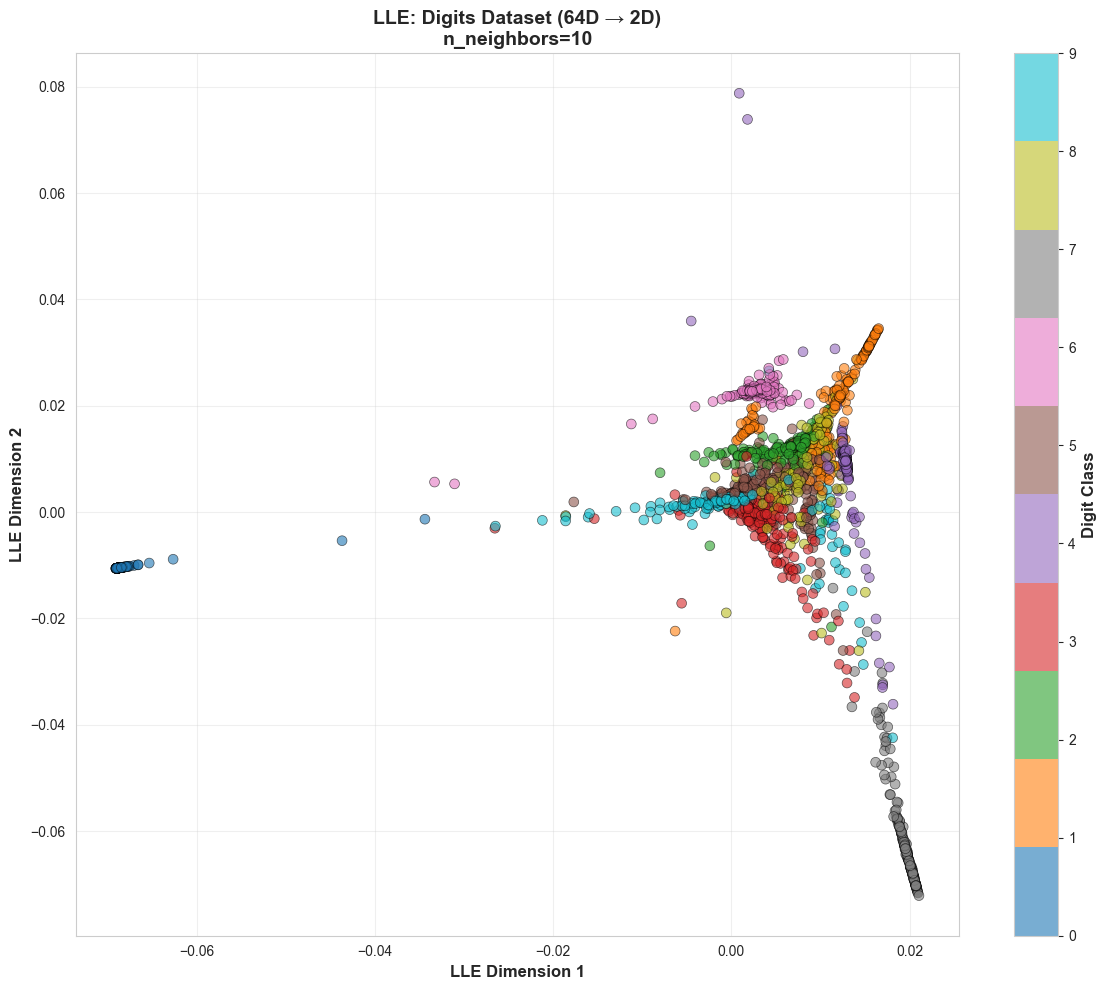


🔍 Observations:
  • Preserves local neighborhood structure
  • May show more distortion than other methods
  • Works well when data has smooth, locally linear manifold


In [38]:
# Apply LLE
print("Applying LLE...")
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_lle = lle.fit_transform(X_digits_scaled)

print("="*80)
print(f"Original dimensions: {X_digits_scaled.shape[1]}")
print(f"Reduced dimensions:  {X_lle.shape[1]}")
print(f"Reconstruction error: {lle.reconstruction_error_:.4f}")
print("="*80)

# Visualize LLE in 2D
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(X_lle[:, 0], X_lle[:, 1], c=y_digits, cmap='tab10',
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
cbar.set_label('Digit Class', fontsize=12, fontweight='bold')

ax.set_xlabel('LLE Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('LLE Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('LLE: Digits Dataset (64D → 2D)\nn_neighbors=10', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Observations:")
print("  • Preserves local neighborhood structure")
print("  • May show more distortion than other methods")
print("  • Works well when data has smooth, locally linear manifold")

## _Part 5: Side-by-Side Comparison_

Let's compare all methods side-by-side to see their differences!

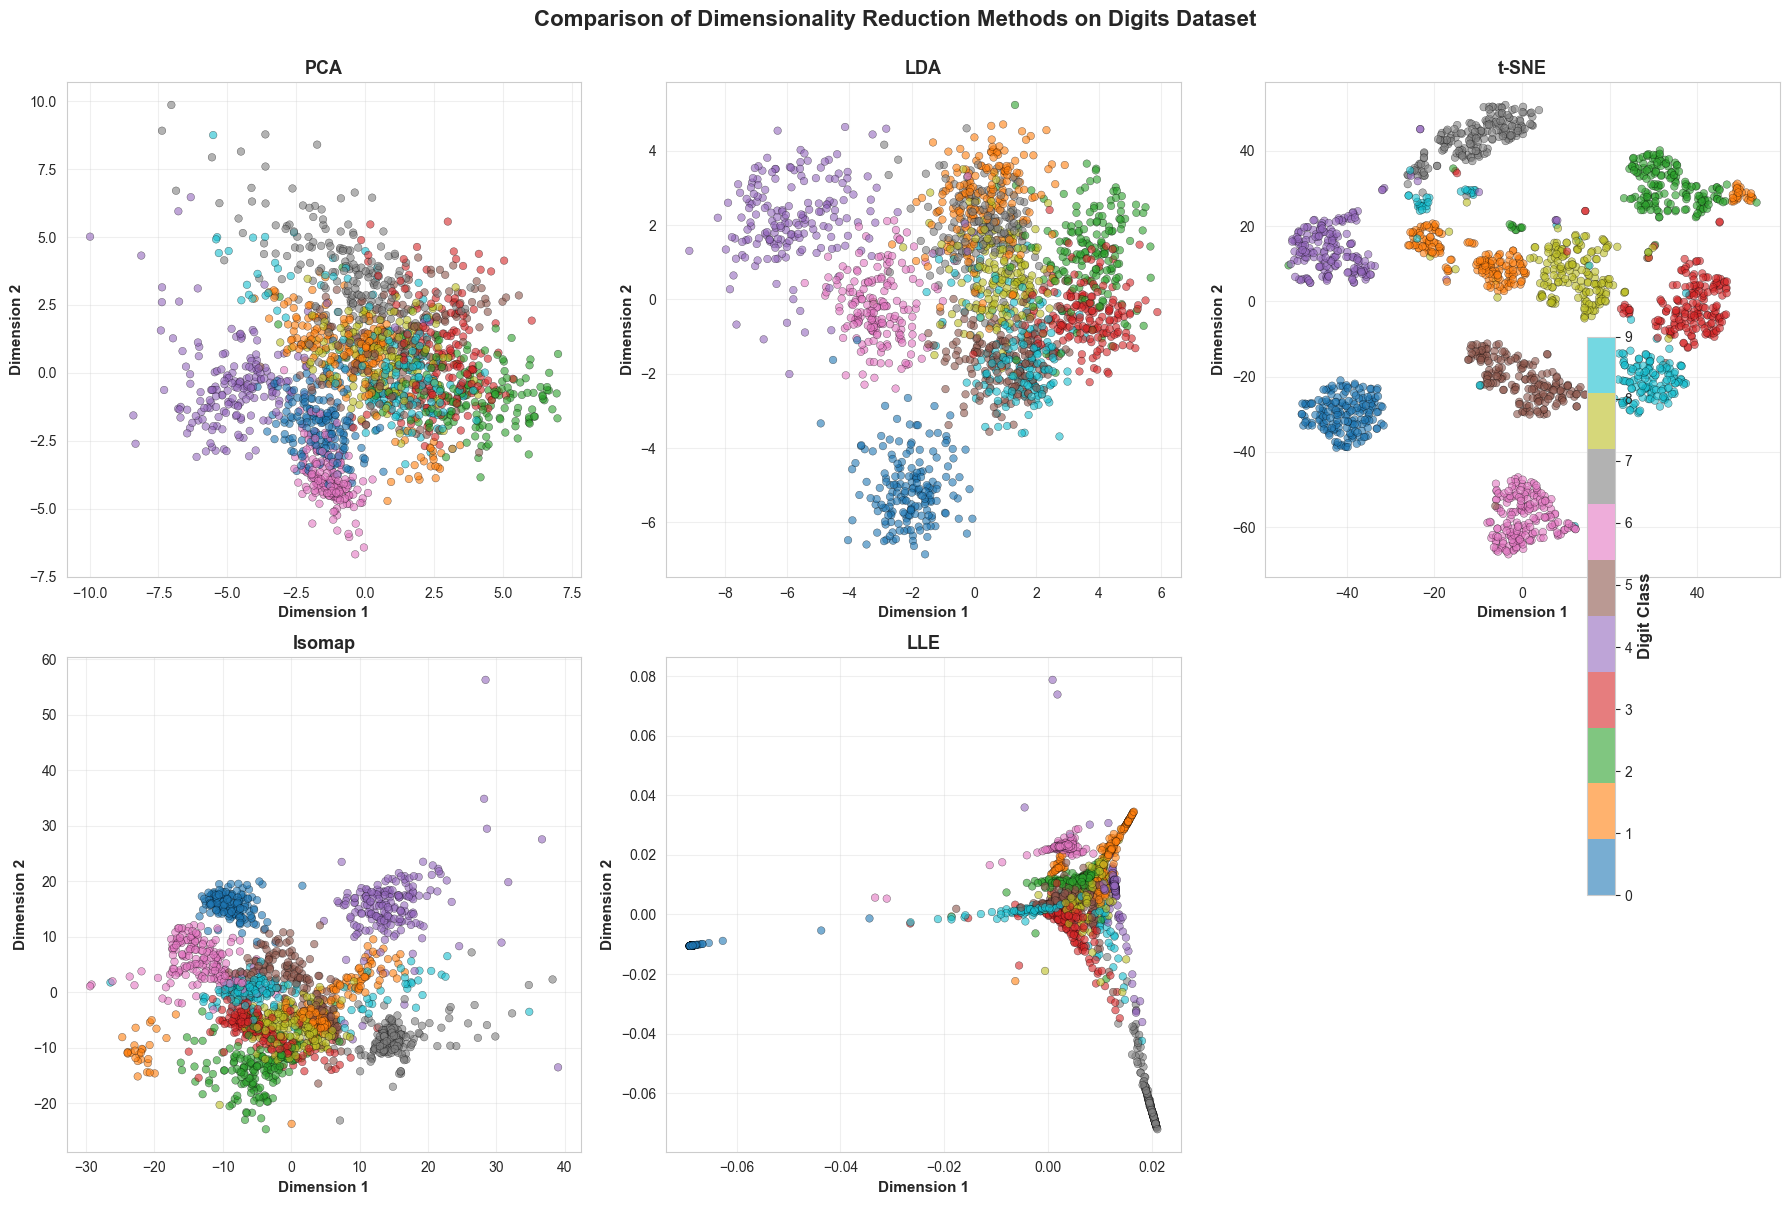


📊 Visual Comparison Summary:
PCA:    Global structure, some overlap, fast
LDA:    Better class separation (uses labels), linear
t-SNE:  Excellent clusters, slow, best for visualization
Isomap: Geodesic distances, moderate separation
LLE:    Local geometry, can have distortions


In [39]:
# Create comprehensive comparison plot
methods = ['PCA', 'LDA', 't-SNE', 'Isomap', 'LLE']
embeddings = [X_pca, X_lda, X_tsne, X_isomap, X_lle]

# Add UMAP if available
if UMAP_AVAILABLE:
    methods.append('UMAP')
    embeddings.append(X_umap)

# Determine grid size
n_methods = len(methods)
n_cols = 3
n_rows = (n_methods + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.ravel()

for idx, (method, embedding) in enumerate(zip(methods, embeddings)):
    scatter = axes[idx].scatter(embedding[:, 0], embedding[:, 1], c=y_digits, cmap='tab10',
                                alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
    
    axes[idx].set_xlabel('Dimension 1', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Dimension 2', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{method}', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)

# Hide extra subplots
for idx in range(n_methods, len(axes)):
    axes[idx].axis('off')

# Add colorbar
cbar = fig.colorbar(scatter, ax=axes, ticks=range(10), fraction=0.02, pad=0.04)
cbar.set_label('Digit Class', fontsize=12, fontweight='bold')

plt.suptitle('Comparison of Dimensionality Reduction Methods on Digits Dataset', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n📊 Visual Comparison Summary:")
print("="*80)
print("PCA:    Global structure, some overlap, fast")
print("LDA:    Better class separation (uses labels), linear")
print("t-SNE:  Excellent clusters, slow, best for visualization")
if UMAP_AVAILABLE:
    print("UMAP:   Similar to t-SNE, faster, preserves global structure better")
print("Isomap: Geodesic distances, moderate separation")
print("LLE:    Local geometry, can have distortions")
print("="*80)

## _Part 6: Practical Guidelines — Which Method to Choose?_

### Decision Tree for Choosing Dimensionality Reduction:

```
START: What is your goal?
│
├─ GOAL: Quick visualization and exploration
│  └─ USE: PCA (fast, interpretable, good first step)
│
├─ GOAL: Visualize cluster structure beautifully
│  ├─ Dataset size < 10,000?
│  │  └─ USE: t-SNE (best visualization quality)
│  └─ Dataset size > 10,000?
│     └─ USE: UMAP (faster, scales better)
│
├─ GOAL: Maximize class separation (have labels)
│  └─ USE: LDA (supervised, good for classification)
│
├─ GOAL: Preserve distances along manifold
│  └─ USE: Isomap (geodesic distances)
│
├─ GOAL: Preprocessing for machine learning
│  ├─ Linear model?
│  │  └─ USE: PCA or LDA
│  └─ Tree-based model?
│     └─ DON'T reduce dimensions (trees handle high-D well)
│
└─ GOAL: Feature extraction and noise reduction
   └─ USE: PCA (reversible, variance-based)
```

### Quick Reference Table:

| Method | Speed | Preserves | Best Use Case | Avoid When |
|--------|-------|-----------|---------------|------------|
| **PCA** | ⚡⚡⚡ Fast | Global variance | Quick exploration, preprocessing | Need nonlinear patterns |
| **LDA** | ⚡⚡⚡ Fast | Class separation | Supervised learning, classification | No labels available |
| **t-SNE** | ⚡ Slow | Local clusters | Publication plots, cluster viz | Large datasets (>10k) |
| **UMAP** | ⚡⚡ Medium | Local + global | Modern alternative to t-SNE | Need deterministic results |
| **Isomap** | ⚡⚡ Medium | Geodesic distances | Smooth manifolds | Noisy data |
| **LLE** | ⚡⚡ Medium | Local geometry | Locally linear manifolds | High noise, outliers |

### Common Workflow:

**For Exploratory Data Analysis:**
1. Start with **PCA** → quick overview, understand variance
2. Try **t-SNE or UMAP** → see detailed cluster structure
3. If you have labels, compare with **LDA** → see class separation

**For Machine Learning Pipeline:**
1. Use **PCA** for dimensionality reduction before modeling
2. Use **LDA** if you're doing classification
3. Don't use t-SNE/UMAP (they're for visualization, not features!)

**For Publication Figures:**
1. Use **t-SNE** for beautiful cluster visualization
2. Try different perplexity values
3. Consider **UMAP** as modern alternative
4. Include **PCA** for comparison (shows it's not just about variance)

## _Part 7: Bonus — 3D Visualization_

Sometimes 3 dimensions can provide additional insight that 2D misses. Let's visualize PCA and t-SNE in 3D!

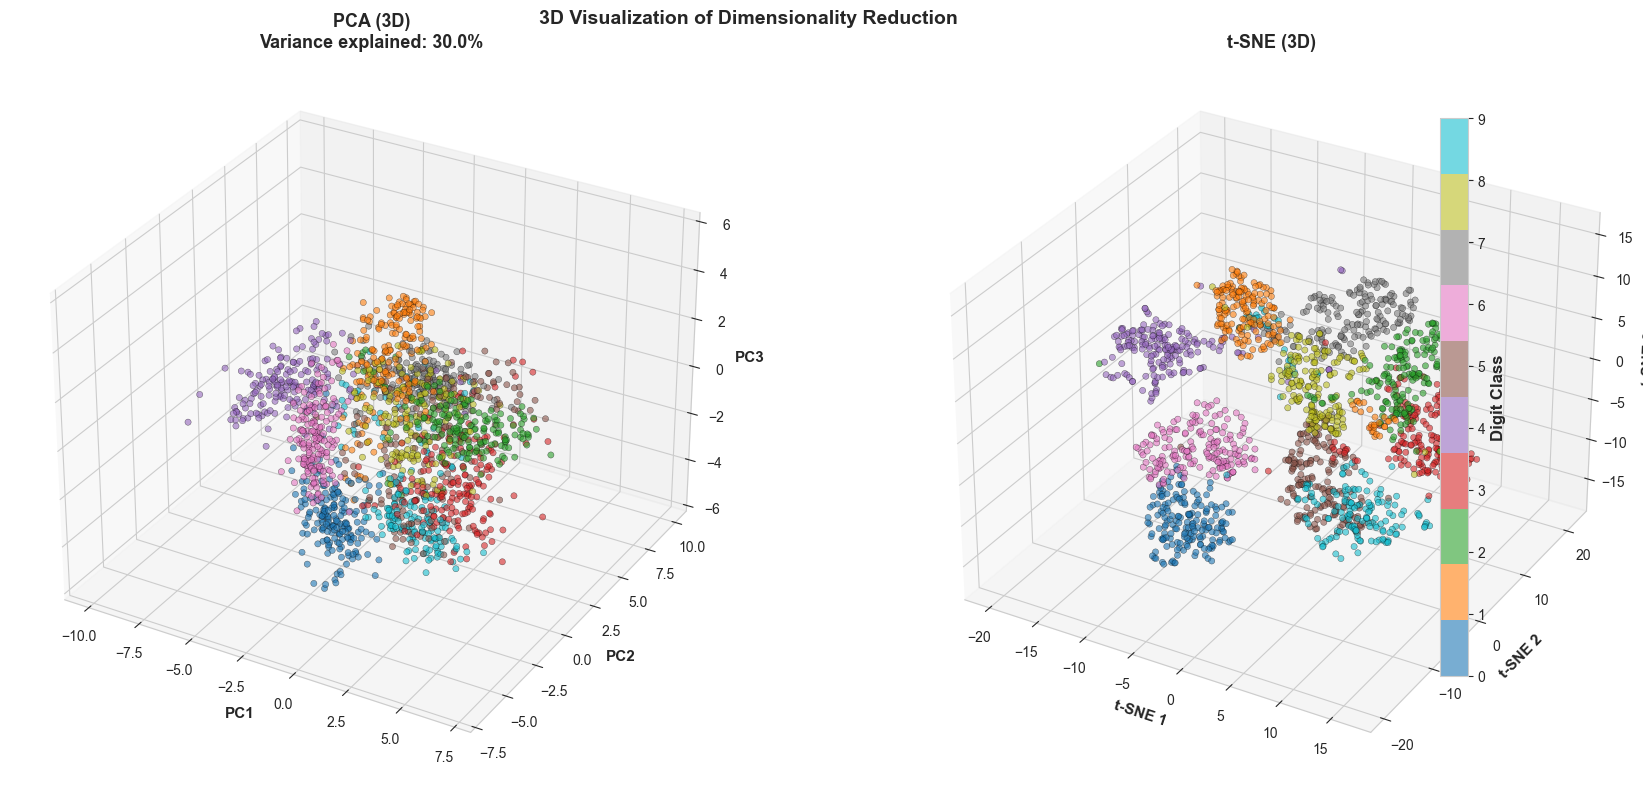


💡 3D can sometimes reveal structure hidden in 2D projections!
   But be careful: 3D plots can be hard to interpret in static images.


In [40]:
# Apply PCA and t-SNE in 3D
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_digits_scaled)

tsne_3d = TSNE(n_components=3, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_digits_scaled)

# Create 3D plots
fig = plt.figure(figsize=(18, 8))

# PCA 3D
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                       c=y_digits, cmap='tab10', alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
ax1.set_xlabel('PC1', fontsize=11, fontweight='bold')
ax1.set_ylabel('PC2', fontsize=11, fontweight='bold')
ax1.set_zlabel('PC3', fontsize=11, fontweight='bold')
ax1.set_title('PCA (3D)\nVariance explained: {:.1f}%'.format(pca_3d.explained_variance_ratio_.sum()*100),
              fontsize=13, fontweight='bold')

# t-SNE 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
                       c=y_digits, cmap='tab10', alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
ax2.set_xlabel('t-SNE 1', fontsize=11, fontweight='bold')
ax2.set_ylabel('t-SNE 2', fontsize=11, fontweight='bold')
ax2.set_zlabel('t-SNE 3', fontsize=11, fontweight='bold')
ax2.set_title('t-SNE (3D)', fontsize=13, fontweight='bold')

# Add colorbar
cbar = fig.colorbar(scatter1, ax=[ax1, ax2], ticks=range(10), fraction=0.02, pad=0.1)
cbar.set_label('Digit Class', fontsize=12, fontweight='bold')

plt.suptitle('3D Visualization of Dimensionality Reduction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 3D can sometimes reveal structure hidden in 2D projections!")
print("   But be careful: 3D plots can be hard to interpret in static images.")

## _Conclusion: Summary and Key Takeaways_

Congratulations! You've completed a comprehensive exploration of dimensionality reduction.

### What We Learned:

#### 1. The Curse of Dimensionality
- ❌ Data becomes sparse exponentially as dimensions increase
- ❌ Distances concentrate — all points become equidistant
- ❌ Volume concentrates near the boundary of hyperspheres
- ✅ Dimensionality reduction is essential, not optional!

#### 2. Why Dimensionality Reduction?
- **Visualization**: Make high-dimensional data visible (2D/3D)
- **Speed**: Faster training and prediction
- **Noise reduction**: Focus on signal, discard noise
- **Avoid overfitting**: Simpler models generalize better
- **Understanding**: Discover patterns and relationships

#### 3. Methods We Explored:

| Method | Type | Best For | Key Insight |
|--------|------|----------|-------------|
| **PCA** | Linear | Quick exploration, preprocessing | Finds directions of maximum variance |
| **LDA** | Linear (supervised) | Class separation | Maximizes between-class variance |
| **t-SNE** | Nonlinear | Beautiful visualizations | Preserves local structure, reveals clusters |
| **UMAP** | Nonlinear | Fast, scalable visualization | Best of t-SNE + speed + global structure |
| **Isomap** | Nonlinear | Manifold learning | Preserves geodesic (curved) distances |
| **LLE** | Nonlinear | Local geometry | Reconstructs points from neighbors |

### Best Practices:

✅ **Always standardize/scale** features before applying DR (except for tree-based methods)

✅ **Start with PCA** — it's fast and gives you a baseline

✅ **Use t-SNE or UMAP** for publication-quality visualizations

✅ **Try multiple methods** — different methods reveal different aspects

✅ **Don't use t-SNE/UMAP for feature extraction** — use PCA instead

✅ **Check explained variance** (for PCA) to decide how many components to keep

✅ **Tune hyperparameters** (perplexity for t-SNE, n_neighbors for UMAP/Isomap)

⚠️ **Remember**: Dimensionality reduction loses information — it's a tradeoff!

### Next Steps:

Now that you understand dimensionality reduction:
- Apply these methods to your own datasets
- Use DR for exploratory data analysis
- Incorporate PCA into your ML pipelines
- Create beautiful visualizations with t-SNE/UMAP
- Understand when and why to reduce dimensions

### Resources for Further Learning:

- **PCA**: [StatQuest YouTube](https://www.youtube.com/watch?v=FgakZw6K1QQ)
- **t-SNE**: [Original Paper by van der Maaten & Hinton (2008)](https://jmlr.org/papers/v9/vandermaaten08a.html)
- **UMAP**: [UMAP Documentation](https://umap-learn.readthedocs.io/)
- **Interactive Demo**: [Distill.pub on t-SNE](https://distill.pub/2016/misread-tsne/)

---

**Remember**: *High dimensions are cursed, but with the right tools, we can break the curse!*